In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d

from multiprocessing import Pool
from functools import partial

import MicroTools as micro
import MicroTools.plot_tools as pt

import param_scan
from param_scan import fast_histogram
from tqdm.notebook import tqdm  # Note the change here
# from tqdm.auto import tqdm

from ipywidgets import IntProgress
from IPython.display import display

In [ ]:
def run_scan_osc_dec(kwargs, filename, Npoints=10, path_results = "fit_data/"):

    gvec = np.geomspace(1e-1, 3.5, Npoints)
    mvec = np.geomspace(1e-1, 1e2, Npoints)
    Ue4Sq = np.geomspace(1e-4, 0.49, Npoints)
    Umu4Sq = np.geomspace(1e-4, 0.49, Npoints)
    # Cartesian product of grid -- already imposes unitarity and pertubatirbity of g
    paramlist = param_scan.create_grid_of_params(g=gvec, m4=mvec, Ue4Sq=Ue4Sq, Um4Sq=Umu4Sq)

    # Pure oscillation method
    func_scan = partial(param_scan.DecayReturnMicroBooNEChi2, **kwargs)

    with Pool() as pool:
        # res = pool.map(func_scan, paramlist)
        res = np.array(list(tqdm(pool.imap(func_scan, paramlist), total=len(paramlist))))

    param_scan.write_pickle(f"{path_results}/{filename}", res)
    return res

In [130]:
# Common attributes to all osc+dec scans
kwargs_common = {
    'oscillations': True, 
    'decay': True, 
    'decouple_decay': False, 
    'include_antineutrinos': True, 
    'n_replications': 10}

# Appearance only
kwargs_apponly = {
    'disappearance': False, 
    'use_numu_MC': False,
    'undo_numu_normalization': False,
    **kwargs_common}

# Include disappearance and energy degradation
kwargs_std = {
    'disappearance': True, 
    'use_numu_MC': True,
    'energy_degradation': True, 
    'undo_numu_normalization': False,
    **kwargs_common}

#Include disappearance, but no energy degradation
kwargs_noed = {
    'disappearance': True, 
    'use_numu_MC': True,
    'energy_degradation': False, 
    'undo_numu_normalization': False,
    **kwargs_common}

#Oscillation only, no antineutrinos
kwargs_nobar_osc = {
'oscillations': True, 
'decay': False, 
'decouple_decay': False, 
'disappearance': True, 
'energy_degradation': False, 
'use_numu_MC': True, 
'undo_numu_normalization': False,
'n_replications': 10,
'include_antineutrinos': False
}

# osc+decay, no antineutrinos
kwargs_nobar = {
'oscillations': True, 
'decay': True, 
'decouple_decay': False, 
'disappearance': True, 
'energy_degradation': False, 
'use_numu_MC': True, 
'undo_numu_normalization': False,
'n_replications': 10,
'include_antineutrinos': False
}

In [ ]:
_ = run_scan_osc_dec(kwargs_std, 'TZ_decay_dis', Npoints=2)

In [137]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 2-dimensions
# --------------------------------------------------------------------------------
def create_grid_of_params(g, m4, Ue4Sq, Um4Sq):
    paramlist_decay = np.array(np.meshgrid(g, m4, Ue4Sq, Um4Sq)).T.reshape(-1, 4)
    return [{"g": g, "m4": m4, "Ue4Sq": Ue4Sq, "Um4Sq": Um4Sq} for g, m4, Ue4Sq, Um4Sq in paramlist_decay]

path_results = "fit_data/"
Npoints = 30

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
x_Vec = np.geomspace(1e-4/4, 0.89/4, Npoints)

# Range of m4 for sterile decay model scanned over 0.1 to 100 in 30 steps
y_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=1, m4=y_Vec, Ue4Sq=0.05, Um4Sq=x_Vec)

# Pure oscillation method
#func_2Dscan_osc = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=True, decay=False, decouple_decay=False, disappearance=True, energy_degradation=False, use_numu_MC=True, include_antineutrinos=False)
func_2Dscan_osc = partial(param_scan.DecayReturnMicroBooNEChi2, **kwargs_nobar)

# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_2Dscan_osc, paramlist_decay)
#np.save(f"{path_results}/App_gm4_Um4sq_osc_decay_deg_g=0.1_Ue4Sq=0.05_test", res)
np.save(f"{path_results}/g=1e=0.05_nobar", res)

## Profiling over $\textrm{g}$ and $|U_{e4}|^2$ for minimal MicroBooNE $\chi^2$

In [ ]:
Npoints = 50
# Range of g for sterile decay model scanned over 1e-1 to 1e2 in 15 steps
g = np.geomspace(1e-1, 1e2, Npoints)

# Range of m scanned over 1e-1 to 1e2 in 15 steps
m = np.geomspace(1e-1, 1e2, Npoints)

# Range of |U_{e4}|^2 scanned over 1e-4 to 0.49 in 15 steps
e = np.geomspace(1e-4, 0.49, Npoints)

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 0.49 in 15 steps
mu = np.geomspace(1e-4, 0.49, Npoints)

data = np.load(f"{path_results}/App_g_m4_Ue4sq_Um4sq_deg_KJK50.npy", allow_pickle=True)
#fig, ax1 = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
#xmin, xmax, ymin, ymax = 1e-4, 3e-2, 1e-1, 1e2

Npoints = 50
slice_marg = []

for i in range(Npoints):
    slice_m = data[data[:, 1] == m[i], :]
    for j in range(Npoints):
        slice_mu = slice_m[slice_m[:, 3] == mu[j], :]
        if slice_mu[:,-2].size:
            min_entry = slice_mu[np.argmin(slice_mu[:, -2])]
        else:
            continue
        slice_marg.append(min_entry)
slice_marg = np.array(slice_marg)
MicroApp_chi2 = slice_marg[:,-2]
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MVec = slice_marg[:,3]
#MVec = [4 * slice_marg[i,2] * slice_marg[i,3] for i in range(len(slice_marg))]
gm4VecT = slice_marg[:,1]**2
fig, ax = pt.std_fig(figsize=(pt.std_figsize[0], pt.std_figsize[1]*1.5))
xmin, xmax, ymin, ymax = 1e-4, 1, 1e-2, 1e4
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)

levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [6.18, 1e10]

ax.tricontourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1)

## Slices, 2D scan

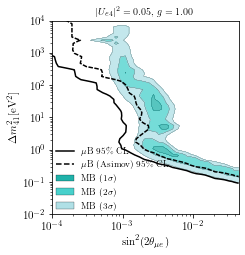

In [138]:
# 4D parameter scan
filename = 'g=1e=0.05_nobar'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.npy", allow_pickle=True)
evalue = 0.05
gvalue = 1
# Filter entries for fixed g and e
MiniApp_chi2 = data[:,-3]
MicroApp_chi2 = data[:,-2]
MicroApp_Asimov_chi2 = data[:,-1]
MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

MVec, gm4VecT = 4 * evalue * data[:,3], data[:,1]**2

# rearrange data to use contour. Ignore if using tricontour
"""MVec = np.unique(MVec)
gm4VecT = np.unique(gm4VecT)
MicroApp_deltachi2 = np.transpose(MicroApp_deltachi2.reshape(len(MVec), len(gm4VecT)))
MicroApp_Asimov_deltachi2 = np.transpose(MicroApp_Asimov_deltachi2.reshape(len(MVec), len(gm4VecT)))"""

fig, ax = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 0.89*evalue, 1e-2, 1e4
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
ax.set_title('$|U_{e4}|^2=%.2f$, $g=%.2f$'%(evalue,gvalue), fontsize=10)
#ax.text(2e-4, 3e-2, '$|U_{e4}|^2=%.4f$\n$g=%.2f$'%(evalue,gvalue), fontsize = 15)
"""levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [11.83, 1e10]
ax.contourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1, linewidths=1.5)
ax.contour(MVec, gm4VecT, MicroApp_Asimov_deltachi2, levels=levsMicroB, colors=['black'], alpha=1, linewidths=1, linestyles=['--'])
"""
le = len(np.unique(MVec))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MiniApp_deltachi2, **kwargs_interp)
cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['lightseagreen','mediumturquoise','powderblue'], zorder=1, alpha=0.75)
cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax.fill([], [], edgecolor='black', facecolor='lightseagreen', lw=0.25, label='MB ($1 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='mediumturquoise', lw=0.25, label='MB ($2 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='powderblue', lw=0.25, label='MB ($3 \sigma$)')
ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

ax.legend(loc=(0,0), fontsize=9)
fig.savefig(f"{micro.path_plots}/{filename}.pdf", bbox_inches='tight', dpi=300)


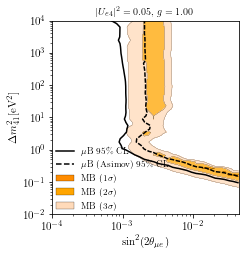

In [140]:
# Oscillation only
# 4D parameter scan
filename = 'g=1e=0.05_nobar_osc'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.npy", allow_pickle=True)
evalue = 0.05
gvalue = 1
# Filter entries for fixed g and e
MiniApp_chi2 = data[:,-3]
MicroApp_chi2 = data[:,-2]
MicroApp_Asimov_chi2 = data[:,-1]
MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

MVec, gm4VecT = 4 * evalue * data[:,3], data[:,1]**2

# rearrange data to use contour. Ignore if using tricontour
"""MVec = np.unique(MVec)
gm4VecT = np.unique(gm4VecT)
MicroApp_deltachi2 = np.transpose(MicroApp_deltachi2.reshape(len(MVec), len(gm4VecT)))
MicroApp_Asimov_deltachi2 = np.transpose(MicroApp_Asimov_deltachi2.reshape(len(MVec), len(gm4VecT)))"""

fig, ax = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 0.89*evalue, 1e-2, 1e4
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$\sin^2(2\theta_{\mu e})$", fontproperties=pt.font)
ax.set_title('$|U_{e4}|^2=%.2f$, $g=%.2f$'%(evalue,gvalue), fontsize=10)
#ax.text(2e-4, 3e-2, '$|U_{e4}|^2=%.4f$\n$g=%.2f$'%(evalue,gvalue), fontsize = 15)
"""levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [11.83, 1e10]
ax.contourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1, linewidths=1.5)
ax.contour(MVec, gm4VecT, MicroApp_Asimov_deltachi2, levels=levsMicroB, colors=['black'], alpha=1, linewidths=1, linestyles=['--'])
"""
le = len(np.unique(MVec))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MiniApp_deltachi2, **kwargs_interp)
cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['darkorange','orange','peachpuff'], zorder=1, alpha=0.75)
cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax.fill([], [], edgecolor='black', facecolor='darkorange', lw=0.25, label='MB ($1 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='orange', lw=0.25, label='MB ($2 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='peachpuff', lw=0.25, label='MB ($3 \sigma$)')
ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

ax.legend(loc=(0,0), fontsize=9)
fig.savefig(f"{micro.path_plots}/{filename}.pdf", bbox_inches='tight', dpi=300)


## decoupled

In [124]:
# --------------------------------------------------------------------------------
#                 Setting up Parameter Scan -- 2-dimensions
# --------------------------------------------------------------------------------
def create_grid_of_params(g, m4, Ue4Sq, Um4Sq):
    paramlist_decay = np.array(np.meshgrid(g, m4, Ue4Sq, Um4Sq)).T.reshape(-1, 4)
    return [{"g": g, "m4": m4, "Ue4Sq": Ue4Sq, "Um4Sq": Um4Sq} for g, m4, Ue4Sq, Um4Sq in paramlist_decay]

path_results = "fit_data/"
Npoints = 15

# Range of |U_{\mu4}|^2 scanned over 1e-4 to 1 in 30 steps
x_Vec = np.geomspace(1e-4, 0.89, Npoints)

# Range of m4 for sterile decay model scanned over 0.1 to 100 in 30 steps
y_Vec = np.geomspace(1e-1, 1e2, Npoints)

# Cartesian product of grid
paramlist_decay = create_grid_of_params(g=2.5, m4=y_Vec, Ue4Sq=0, Um4Sq=x_Vec)

# Pure oscillation method
func_2Dscan_osc = partial(param_scan.DecayReturnMicroBooNEChi2, oscillations=False, decay=True, decouple_decay=True, disappearance=True, energy_degradation=True, use_numu_MC=True, include_antineutrinos=False)
# Note: numu disappearance is on
# Designed to run in parallel. Set the argument of "Pool" to 1 to disable this.
pool = Pool()
res = pool.map(func_2Dscan_osc, paramlist_decay)
#np.save(f"{path_results}/App_gm4_Um4sq_osc_decay_deg_g=0.1_Ue4Sq=0.05_test", res)
np.save(f"{path_results}/g=2.5_decoupled_decay_nobar", res)

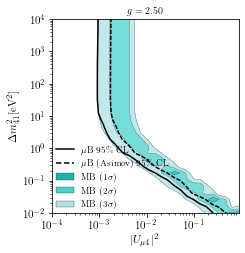

In [125]:
# 4D parameter scan
filename = 'g=2.5_decoupled_decay_nobar'
path_results = "fit_data/"
data = np.load(f"{path_results}/{filename}.npy", allow_pickle=True)
gvalue = 2.5
# Filter entries for fixed g and e
MiniApp_chi2 = data[:,-3]
MicroApp_chi2 = data[:,-2]
MicroApp_Asimov_chi2 = data[:,-1]
MiniApp_deltachi2 = MiniApp_chi2 - np.min(MiniApp_chi2)
MicroApp_deltachi2 = MicroApp_chi2 - np.min(MicroApp_chi2)
MicroApp_Asimov_deltachi2 = MicroApp_Asimov_chi2 - np.min(MicroApp_Asimov_chi2)

MVec, gm4VecT = data[:,3], data[:,1]**2

# rearrange data to use contour. Ignore if using tricontour
"""MVec = np.unique(MVec)
gm4VecT = np.unique(gm4VecT)
MicroApp_deltachi2 = np.transpose(MicroApp_deltachi2.reshape(len(MVec), len(gm4VecT)))
MicroApp_Asimov_deltachi2 = np.transpose(MicroApp_Asimov_deltachi2.reshape(len(MVec), len(gm4VecT)))"""

fig, ax = pt.std_fig(figsize=(3.2, 1.5 * 2.3617))
xmin, xmax, ymin, ymax = 1e-4, 0.89, 1e-2, 1e4
ax.set_xscale('log')
ax.set_yscale('log')
ax.axis([xmin, xmax, ymin, ymax])
#ax.set_ylabel(r'$g_D m_4 [\mathrm{eV}]$', fontproperties=pt.font)
ax.set_ylabel(r'$\Delta m_{41}^2 [\mathrm{eV^2}]$', fontproperties=pt.font)
ax.set_xlabel(r"$|U_{\mu 4}|^2$", fontproperties=pt.font)
ax.set_title('$g=%.2f$'%(gvalue), fontsize=10)
#ax.text(2e-4, 3e-2, '$|U_{e4}|^2=%.4f$\n$g=%.2f$'%(evalue,gvalue), fontsize = 15)
"""levs0MB = np.min(MicroApp_chi2)
levsMiniB = [0, 2.30, 6.18, 11.83]
levsMicroB = [11.83, 1e10]
ax.contourf(MVec, gm4VecT, MicroApp_deltachi2, levels=levsMicroB, cmap='Blues', alpha=1, linewidths=1.5)
ax.contour(MVec, gm4VecT, MicroApp_Asimov_deltachi2, levels=levsMicroB, colors=['black'], alpha=1, linewidths=1, linestyles=['--'])
"""
le = len(np.unique(MVec))
kwargs_interp = {'fine_gridx': le*2,  
                        'fine_gridy': le*2, 
                        'logx':True, 
                        'logy':True,
                        }

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MiniApp_deltachi2, **kwargs_interp)
cs = ax.contourf(X,Y,Z, levels=[0, 2.3, 6.18, 11.83], colors=['lightseagreen','mediumturquoise','powderblue'], zorder=1, alpha=0.75)
cs = ax.contour(X,Y,Z, levels=[2.3, 6.18, 11.83], colors=['black','black','black'], linewidths=0.25, zorder=1, alpha=0.75)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], zorder=2)

X, Y, Z = pt.interp_grid(MVec, gm4VecT, MicroApp_Asimov_deltachi2, **kwargs_interp)
cs = ax.contour(X,Y,Z, levels=[5.99], colors=['black'], linestyles=[(1,(3,1))], zorder=2)
# ax2.scatter(sin2theta, dm4SQR, s=1)

ax.fill([], [], edgecolor='black', facecolor='lightseagreen', lw=0.25, label='MB ($1 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='mediumturquoise', lw=0.25, label='MB ($2 \sigma$)')
ax.fill([], [], edgecolor='black', facecolor='powderblue', lw=0.25, label='MB ($3 \sigma$)')
ax.plot([], [], color='black', lw=1.5, label='$\mu$B 95\% CL')
ax.plot([], [], color='black', lw=1.5, ls='--', label='$\mu$B (Asimov) 95\% CL')

ax.legend(loc=(0,0), fontsize=9)
fig.savefig(f"{micro.path_plots}/{filename}.pdf", bbox_inches='tight', dpi=300)


## Test migration matrix

In [ ]:
import MiniTools as mini

# load all MC samples
Ereco_nue, Etrue_nue, Length_nue, Weight_nue = mini.apps.get_MC_from_data_release_nue(mode="fhc", year="2022" )
Ereco_numu, Etrue_numu, Length_numu, Weight_numu = (mini.apps.get_MC_from_data_release_numu(mode="fhc", year="2022"))
Ereco_nuebar, Etrue_nuebar, Length_nuebar, Weight_nuebar = (mini.apps.get_MC_from_data_release_nue(mode="rhc", year="2022"))
Ereco_numubar, Etrue_numubar, Length_numubar, Weight_numubar = (mini.apps.get_MC_from_data_release_numu(mode="rhc", year="2022"))

# Pre-computed migration matrices
migration_matrix_official_bins_numu = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_numu.pkl"
)
migration_matrix_official_bins_nue_11bins = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_nue_11bins.pkl"
)
migration_matrix_official_bins_nue_13bins = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_nue_13bins.pkl"
)

migration_matrix_official_bins_numubar = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_numubar.pkl"
)
migration_matrix_official_bins_nuebar_11bins = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_nuebar_11bins.pkl"
)
migration_matrix_official_bins_nuebar_13bins = mini.apps.pickle_read(
    "MiniTools/include/migration_matrices/migration_matrix_official_bins_nuebar_13bins.pkl"
)

bins = param_scan.MB_Ereco_official_bins
bin_w = np.diff(bins)
bins_numu = param_scan.MB_Ereco_official_bins_numu
bin_numu_w = np.diff(bins_numu)

mig_rate_nue = np.dot(
    param_scan.fast_histogram(
        Etrue_nue, bins=param_scan.e_prod_e_int_bins, weights=Weight_nue
    )[0],
    migration_matrix_official_bins_nue_11bins,
)

std_rate_nue=param_scan.fast_histogram(Ereco_nue, weights=Weight_nue, bins = bins)[0]

mig_rate_nuebar = np.dot(
    param_scan.fast_histogram(
        Etrue_nuebar, bins=param_scan.e_prod_e_int_bins, weights=Weight_nuebar
    )[0],
    migration_matrix_official_bins_nuebar_11bins,
)

std_rate_nuebar=param_scan.fast_histogram(Ereco_nuebar, weights=Weight_nuebar, bins = bins)[0]

mig_rate_numu = np.dot(
    param_scan.fast_histogram(
        Etrue_numu, bins=param_scan.e_prod_e_int_bins_numu, weights=Weight_numu
    )[0],
    migration_matrix_official_bins_numu,
)

std_rate_numu=param_scan.fast_histogram(Ereco_numu, weights=Weight_numu, bins = bins_numu)[0]

mig_rate_numubar = np.dot(
    param_scan.fast_histogram(
        Etrue_numubar, bins=param_scan.e_prod_e_int_bins_numu, weights=Weight_numubar
    )[0],
    migration_matrix_official_bins_numubar,
)

std_rate_numubar=param_scan.fast_histogram(Ereco_numubar, weights=Weight_numubar, bins = bins_numu)[0]

plt.hist(bins[:-1], weights=1 - std_rate_nue/mig_rate_nue, bins = bins,color='red', histtype='step', label=r'$\nu_e$ rate')
plt.hist(bins[:-1], weights=1 - std_rate_nuebar/mig_rate_nuebar, bins = bins,color='blue', histtype='step', label=r'$\bar\nu_e$ rate')
plt.hist(bins_numu[:-1], weights=1 - std_rate_numu/mig_rate_numu, bins = bins_numu,color='red', histtype='step', ls='--', label=r'$\nu_\mu$ rate')
plt.hist(bins_numu[:-1], weights=1 - std_rate_numubar/mig_rate_numubar, bins = bins_numu,color='blue', histtype='step', ls='--', label=r'$\bar\nu_\mu$ rate')
# plt.step(bins[:-1], std_rate/mig_rate, where='post')
plt.axhline(0, c='black', lw=0.5, ls='--')
plt.xlabel(r'$E_\nu$/GeV')
plt.ylabel(r' $\delta$ = 1 - (binned MC) / (migr matrix)')
plt.xlim(0.0,3)
plt.ylim(-0.02,0.08)
plt.legend()
plt.title("Error introduced when using migr matrix instead of MC samples", fontsize=10)
plt.savefig('plots/error_introduced_migr_matrix.pdf', bbox_inches='tight')
plt.rcParams['figure.figsize'] = [8, 5]

In [ ]:
plt.hist(bins[:-1], weights=mig_rate_nue, bins = bins,color='red', histtype='step', label=r'migrated $\nu_e$ rate')
plt.hist(bins[:-1], weights=std_rate_nue, bins = bins,color='blue', histtype='step', label=r'MC $\nu_e$ rate')
plt.hist(bins_numu[:-1], weights=mig_rate_numu, bins = bins_numu,color='red', histtype='step', ls='--', label=r'migrated $\nu_\mu$ rate')
plt.hist(bins_numu[:-1], weights=std_rate_numu, bins = bins_numu,color='blue', histtype='step', ls='--', label=r'MC $\nu_\mu$ rate')
# plt.step(bins[:-1], std_rate/mig_rate, where='post')
plt.axhline(0, c='black', lw=0.5, ls='--')
plt.xlabel(r'$E_\nu$/GeV')
plt.ylabel(r' Event rate')
plt.xlim(0.0,3)
#plt.ylim(-0.02,0.08)
plt.legend()
plt.title("Event rate from migr matrix vs. MC samples", fontsize=10)
plt.savefig('plots/event_rate_migr_matrix.pdf', bbox_inches='tight')
plt.rcParams['figure.figsize'] = [8, 5]